In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import sqlite3

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

print("=" * 80)
print("MINING EQUIPMENT PREDICTIVE MAINTENANCE - DATA GENERATOR")
print("=" * 80)
print("\nGenerating synthetic data for 4 WA mine sites, 50 haul trucks, 24 months...")
print("\nThis script creates:")
print("  • Equipment master data (trucks, specs, purchase dates)")
print("  • Mine site information (location, roster patterns)")
print("  • 24 months of hourly sensor readings (vibration, temp, pressure)")
print("  • Failure events (10-15% failure rate)")
print("  • Maintenance records with costs")
print("  • Seasonal patterns (higher failures in WA summer)")
print("  • Realistic data quality issues (missing values, outliers)")
print("=" * 80)

# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================

# Date range
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2025, 12, 31)
TOTAL_DAYS = (END_DATE - START_DATE).days

# Mining sites in Western Australia
SITES = [
    {"site_id": "PB01", "site_name": "Port Hedland Operations", "region": "Pilbara",
     "latitude": -20.3114, "longitude": 118.6047, "roster": "2:1", "fleet_size": 15},
    {"site_id": "NW02", "site_name": "Newman Mine", "region": "Pilbara",
     "latitude": -23.3583, "longitude": 119.7333, "roster": "8:6", "fleet_size": 18},
    {"site_id": "KL03", "site_name": "Kalgoorlie Operations", "region": "Goldfields",
     "latitude": -30.7489, "longitude": 121.4658, "roster": "2:1", "fleet_size": 10},
    {"site_id": "CP04", "site_name": "Cape Preston", "region": "Pilbara",
     "latitude": -21.5667, "longitude": 114.9667, "roster": "8:6", "fleet_size": 7}
]

# Equipment specifications
TRUCK_MODELS = [
    {"model": "CAT 793F", "capacity_tonnes": 240, "engine_hp": 2650, "purchase_cost": 5200000},
    {"model": "Komatsu 930E", "capacity_tonnes": 290, "engine_hp": 3500, "purchase_cost": 6100000},
    {"model": "CAT 797F", "capacity_tonnes": 400, "engine_hp": 4000, "purchase_cost": 7500000},
    {"model": "Liebherr T284", "capacity_tonnes": 400, "engine_hp": 3750, "purchase_cost": 7200000}
]

# Sensor thresholds (normal operating ranges)
SENSOR_RANGES = {
    "vibration_g": {"normal": (0.5, 2.5), "warning": (2.5, 4.0), "critical": (4.0, 8.0)},
    "temperature_c": {"normal": (65, 95), "warning": (95, 115), "critical": (115, 140)},
    "pressure_psi": {"normal": (35, 55), "warning": (55, 65), "critical": (65, 85)},
    "hours_operated": {"shift_hours": 11}  # 11-hour shifts typical in mining
}

# ============================================================================
# STEP 1: GENERATE DIMENSION - DIM_SITE
# ============================================================================
print("\n[1/6] Generating DimSite...")

df_sites = pd.DataFrame(SITES)
df_sites['operational_since'] = pd.to_datetime(['2015-03-01', '2012-06-15', '2018-09-01', '2020-01-10'])
df_sites['commodity'] = ['Iron Ore', 'Iron Ore', 'Gold', 'Iron Ore']

print(f"  ✓ Created {len(df_sites)} mine sites")

# ============================================================================
# STEP 2: GENERATE DIMENSION - DIM_EQUIPMENT
# ============================================================================
print("\n[2/6] Generating DimEquipment...")

equipment_records = []
equipment_id = 1

for site in SITES:
    for i in range(site['fleet_size']):
        model_info = random.choice(TRUCK_MODELS)

        # Generate purchase date (trucks purchased between 2015-2022)
        purchase_year = random.randint(2015, 2022)
        purchase_month = random.randint(1, 12)
        purchase_date = datetime(purchase_year, purchase_month, 1)

        # Calculate age and condition
        age_years = (START_DATE - purchase_date).days / 365.25
        condition_score = max(50, 100 - (age_years * 5) + random.uniform(-10, 10))

        equipment_records.append({
            "equipment_id": f"TRK{equipment_id:03d}",
            "site_id": site['site_id'],
            "equipment_type": "Haul Truck",
            "model": model_info['model'],
            "manufacturer": model_info['model'].split()[0],
            "capacity_tonnes": model_info['capacity_tonnes'],
            "engine_horsepower": model_info['engine_hp'],
            "purchase_date": purchase_date,
            "purchase_cost": model_info['purchase_cost'],
            "age_years": round(age_years, 1),
            "condition_score": round(condition_score, 1),
            "status": "Active" if condition_score > 60 else "Watch List"
        })
        equipment_id += 1

df_equipment = pd.DataFrame(equipment_records)
print(f"  ✓ Created {len(df_equipment)} haul trucks across 4 sites")

# ============================================================================
# STEP 3: GENERATE DIMENSION - DIM_DATE
# ============================================================================
print("\n[3/6] Generating DimDate...")

date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')
df_date = pd.DataFrame({
    'date_key': date_range.strftime('%Y%m%d').astype(int),
    'date': date_range,
    'year': date_range.year,
    'quarter': date_range.quarter,
    'month': date_range.month,
    'month_name': date_range.strftime('%B'),
    'day': date_range.day,
    'day_of_week': date_range.dayofweek,
    'day_name': date_range.strftime('%A'),
    'week_of_year': date_range.isocalendar().week,
    'is_weekend': date_range.dayofweek.isin([5, 6]).astype(int),
    'fiscal_year': np.where(date_range.month >= 7, date_range.year + 1, date_range.year)
})

# Add Australian seasons (opposite to Northern Hemisphere)
df_date['season'] = df_date['month'].map({
    12: 'Summer', 1: 'Summer', 2: 'Summer',
    3: 'Autumn', 4: 'Autumn', 5: 'Autumn',
    6: 'Winter', 7: 'Winter', 8: 'Winter',
    9: 'Spring', 10: 'Spring', 11: 'Spring'
})

# WA temperature factor (for seasonal failure patterns)
df_date['temp_factor'] = df_date['month'].map({
    1: 1.3, 2: 1.3, 3: 1.1, 4: 1.0, 5: 0.9, 6: 0.85,
    7: 0.85, 8: 0.9, 9: 1.0, 10: 1.1, 11: 1.2, 12: 1.3
})

print(f"  ✓ Created date dimension with {len(df_date)} days")

# ============================================================================
# STEP 4: GENERATE FACT TABLE - SENSOR READINGS & FAILURES
# ============================================================================
print("\n[4/6] Generating sensor readings and failure events...")
print("  (This may take 2-3 minutes for 24 months of hourly data...)")

sensor_readings = []
failure_events = []
failure_id = 1

for idx, truck in df_equipment.iterrows():
    equipment_id = truck['equipment_id']
    site_id = truck['site_id']
    age_multiplier = 1 + (truck['age_years'] / 20)  # Older trucks fail more

    # Get site roster pattern
    site_info = next(s for s in SITES if s['site_id'] == site_id)
    roster = site_info['roster']

    current_date = START_DATE
    cumulative_hours = truck['age_years'] * 6000  # Assume 6000 hrs/year before tracking
    days_since_last_failure = 0
    is_degrading = False
    degradation_start = None
    failure_in_days = None

    while current_date <= END_DATE:
        date_key = int(current_date.strftime('%Y%m%d'))

        # Roster logic: 2:1 = work 2 weeks, off 1 week; 8:6 = work 8 days, off 6 days
        if roster == "2:1":
            cycle_day = ((current_date - START_DATE).days % 21)
            is_working = cycle_day < 14
        else:  # 8:6
            cycle_day = ((current_date - START_DATE).days % 14)
            is_working = cycle_day < 8

        if is_working:
            # Get seasonal factor from date dimension
            season_factor = df_date[df_date['date'] == current_date]['temp_factor'].values[0]

            # Determine if equipment should start degrading (pre-failure pattern)
            if not is_degrading and random.random() < (0.0008 * age_multiplier * season_factor):
                is_degrading = True
                degradation_start = current_date
                failure_in_days = random.randint(7, 14)  # Fail in 7-14 days

            # Generate 2 readings per shift (simplified from hourly for data size)
            for reading_num in range(2):
                hours_this_shift = random.uniform(5, 6)  # Each reading = ~5-6 hours
                cumulative_hours += hours_this_shift

                # Base sensor values (normal operation)
                base_vibration = random.uniform(0.5, 2.5)
                base_temperature = random.uniform(65, 95)
                base_pressure = random.uniform(35, 55)

                # Apply degradation if in pre-failure window
                if is_degrading:
                    days_degrading = (current_date - degradation_start).days
                    degradation_factor = min(days_degrading / failure_in_days, 1.0)

                    vibration = base_vibration + (degradation_factor * random.uniform(2, 5))
                    temperature = base_temperature + (degradation_factor * random.uniform(15, 40))
                    pressure = base_pressure - (degradation_factor * random.uniform(5, 15))

                    # Trigger failure event
                    if days_degrading >= failure_in_days:
                        failure_type = random.choice([
                            'Engine Overheating', 'Hydraulic Failure', 'Transmission Fault',
                            'Brake System Failure', 'Electrical System Fault', 'Tire Failure'
                        ])

                        downtime_hours = random.uniform(8, 72)
                        repair_cost = random.uniform(15000, 150000)

                        failure_events.append({
                            'failure_id': f'FL{failure_id:04d}',
                            'equipment_id': equipment_id,
                            'site_id': site_id,
                            'failure_date': current_date,
                            'date_key': date_key,
                            'failure_type': failure_type,
                            'severity': random.choice(['Critical', 'Critical', 'Major', 'Major', 'Minor']),
                            'downtime_hours': round(downtime_hours, 1),
                            'repair_cost': round(repair_cost, 2),
                            'labor_hours': round(downtime_hours * random.uniform(1.5, 2.5), 1),
                            'parts_replaced': random.randint(2, 8),
                            'mtbf_hours': round(cumulative_hours - days_since_last_failure * 11, 1)
                        })

                        failure_id += 1
                        is_degrading = False
                        days_since_last_failure = 0

                        # Reset to normal after repair
                        vibration = random.uniform(0.5, 2.0)
                        temperature = random.uniform(65, 90)
                        pressure = random.uniform(38, 52)
                else:
                    vibration = base_vibration
                    temperature = base_temperature
                    pressure = base_pressure

                # Add random noise and occasional outliers/missing values
                if random.random() < 0.02:  # 2% missing values
                    vibration = None
                elif random.random() < 0.01:  # 1% outliers
                    vibration = random.uniform(6, 10)

                if random.random() < 0.03:  # 3% missing values
                    temperature = None
                elif random.random() < 0.01:  # 1% outliers
                    temperature = random.uniform(130, 150)

                if random.random() < 0.02:  # 2% missing values
                    pressure = None

                sensor_readings.append({
                    'reading_id': len(sensor_readings) + 1,
                    'equipment_id': equipment_id,
                    'site_id': site_id,
                    'date_key': date_key,
                    'timestamp': current_date + timedelta(hours=reading_num * 6),
                    'vibration_g': round(vibration, 2) if vibration else None,
                    'temperature_c': round(temperature, 1) if temperature else None,
                    'pressure_psi': round(pressure, 1) if pressure else None,
                    'hours_operated': round(cumulative_hours, 1),
                    'load_tonnes': round(random.uniform(180, truck['capacity_tonnes']), 1),
                    'fuel_consumption_lph': round(random.uniform(180, 280), 1)
                })

        current_date += timedelta(days=1)
        if is_working:
            days_since_last_failure += 1

    if (idx + 1) % 10 == 0:
        print(f"    Progress: {idx + 1}/{len(df_equipment)} trucks processed...")

df_sensor_readings = pd.DataFrame(sensor_readings)
df_failures = pd.DataFrame(failure_events)

print(f"\n  ✓ Generated {len(df_sensor_readings):,} sensor readings")
print(f"  ✓ Generated {len(df_failures)} failure events ({len(df_failures)/len(df_equipment):.1f} failures per truck)")

# ============================================================================
# STEP 5: GENERATE FACT TABLE - MAINTENANCE RECORDS
# ============================================================================
print("\n[5/6] Generating maintenance records...")

maintenance_records = []
maintenance_id = 1

# Scheduled maintenance (every 500 operating hours)
for idx, truck in df_equipment.iterrows():
    equipment_id = truck['equipment_id']
    site_id = truck['site_id']

    # Generate maintenance at 500-hour intervals
    for maint_hours in range(500, 15000, 500):
        # Find approximate date for this hour count
        truck_readings = df_sensor_readings[df_sensor_readings['equipment_id'] == equipment_id]
        reading_at_hours = truck_readings[truck_readings['hours_operated'] >= maint_hours].head(1)

        if not reading_at_hours.empty:
            maint_date = reading_at_hours.iloc[0]['timestamp']
            date_key = reading_at_hours.iloc[0]['date_key']

            maintenance_records.append({
                'maintenance_id': f'MNT{maintenance_id:05d}',
                'equipment_id': equipment_id,
                'site_id': site_id,
                'date_key': date_key,
                'maintenance_date': maint_date,
                'maintenance_type': 'Scheduled',
                'service_category': random.choice([
                    'Preventive Service', 'Oil Change', 'Filter Replacement',
                    'Brake Inspection', 'Tire Rotation', 'Fluid Top-Up'
                ]),
                'duration_hours': round(random.uniform(2, 6), 1),
                'labor_cost': round(random.uniform(800, 2500), 2),
                'parts_cost': round(random.uniform(1500, 8000), 2),
                'technician': random.choice(['Tech-A', 'Tech-B', 'Tech-C', 'Tech-D', 'Tech-E'])
            })
            maintenance_id += 1

# Add unscheduled maintenance from failures
for idx, failure in df_failures.iterrows():
    maintenance_records.append({
        'maintenance_id': f'MNT{maintenance_id:05d}',
        'equipment_id': failure['equipment_id'],
        'site_id': failure['site_id'],
        'date_key': failure['date_key'],
        'maintenance_date': failure['failure_date'],
        'maintenance_type': 'Unscheduled',
        'service_category': failure['failure_type'],
        'duration_hours': failure['downtime_hours'],
        'labor_cost': round(failure['repair_cost'] * 0.4, 2),
        'parts_cost': round(failure['repair_cost'] * 0.6, 2),
        'technician': random.choice(['Tech-A', 'Tech-B', 'Tech-C', 'Tech-D', 'Tech-E'])
    })
    maintenance_id += 1

df_maintenance = pd.DataFrame(maintenance_records)
print(f"  ✓ Created {len(df_maintenance)} maintenance records")
print(f"    - Scheduled: {len(df_maintenance[df_maintenance['maintenance_type'] == 'Scheduled'])}")
print(f"    - Unscheduled: {len(df_maintenance[df_maintenance['maintenance_type'] == 'Unscheduled'])}")

# ============================================================================
# STEP 6: SAVE TO SQLITE DATABASE (STAR SCHEMA)
# ============================================================================
print("\n[6/6] Creating SQLite database with star schema...")

db_path = 'mining_predictive_maintenance.db'
conn = sqlite3.connect(db_path)

# Save dimension tables
df_sites.to_sql('DimSite', conn, if_exists='replace', index=False)
df_equipment.to_sql('DimEquipment', conn, if_exists='replace', index=False)
df_date.to_sql('DimDate', conn, if_exists='replace', index=False)

# Save fact tables
df_sensor_readings.to_sql('FactSensorReadings', conn, if_exists='replace', index=False)
df_failures.to_sql('FactFailures', conn, if_exists='replace', index=False)
df_maintenance.to_sql('FactMaintenance', conn, if_exists='replace', index=False)

conn.close()

print(f"\n  ✓ Database created: {db_path}")
print("\n" + "=" * 80)
print("DATA GENERATION COMPLETE!")
print("=" * 80)
print("\nDatabase contains:")
print(f"  • {len(df_sites)} mine sites")
print(f"  • {len(df_equipment)} haul trucks")
print(f"  • {len(df_date)} days (date dimension)")
print(f"  • {len(df_sensor_readings):,} sensor readings")
print(f"  • {len(df_failures)} failure events")
print(f"  • {len(df_maintenance)} maintenance records")
print("\nNext steps:")
print("  1. Explore data: Use SQL queries to verify data quality")
print("  2. Data cleaning: Handle missing values and outliers")
print("  3. Feature engineering: Create rolling averages, degradation indicators")
print("  4. ML model: Build Random Forest classifier for failure prediction")
print("  5. Power BI: Connect to SQLite and build dashboard")
print("=" * 80)

# ============================================================================
# BONUS: SAVE CSV FILES FOR INSPECTION
# ============================================================================
df_sites.to_csv('dim_site.csv', index=False)
df_equipment.to_csv('dim_equipment.csv', index=False)
df_sensor_readings.to_csv('fact_sensor_readings.csv', index=False)
df_failures.to_csv('fact_failures.csv', index=False)
df_maintenance.to_csv('fact_maintenance.csv', index=False)

print("\nCSV files also exported for inspection:")
print("  • dim_site.csv")
print("  • dim_equipment.csv")
print("  • fact_sensor_readings.csv")
print("  • fact_failures.csv")
print("  • fact_maintenance.csv")

MINING EQUIPMENT PREDICTIVE MAINTENANCE - DATA GENERATOR

Generating synthetic data for 4 WA mine sites, 50 haul trucks, 24 months...

This script creates:
  • Equipment master data (trucks, specs, purchase dates)
  • Mine site information (location, roster patterns)
  • 24 months of hourly sensor readings (vibration, temp, pressure)
  • Failure events (10-15% failure rate)
  • Maintenance records with costs
  • Seasonal patterns (higher failures in WA summer)
  • Realistic data quality issues (missing values, outliers)

[1/6] Generating DimSite...
  ✓ Created 4 mine sites

[2/6] Generating DimEquipment...
  ✓ Created 50 haul trucks across 4 sites

[3/6] Generating DimDate...
  ✓ Created date dimension with 731 days

[4/6] Generating sensor readings and failure events...
  (This may take 2-3 minutes for 24 months of hourly data...)
    Progress: 10/50 trucks processed...
    Progress: 20/50 trucks processed...
    Progress: 30/50 trucks processed...
    Progress: 40/50 trucks processed

In [ ]:
import pandas as pd
import sqlite3

# Connect to database
conn = sqlite3.connect('mining_predictive_maintenance.db')

print("=" * 80)
print("DATABASE VERIFICATION")
print("=" * 80)

# Check each table
tables = ['DimSite', 'DimEquipment', 'DimDate', 'FactSensorReadings', 'FactFailures', 'FactMaintenance']

for table in tables:
    count = pd.read_sql(f"SELECT COUNT(*) as count FROM {table}", conn).iloc[0]['count']
    print(f"\n{table}: {count:,} records")

    # Show sample
    sample = pd.read_sql(f"SELECT * FROM {table} LIMIT 3", conn)
    print(sample.to_string())
    print("-" * 80)

# Key statistics
print("\n" + "=" * 80)
print("KEY STATISTICS")
print("=" * 80)

# Failure rate per truck
failures_query = """
SELECT
    COUNT(DISTINCT equipment_id) as total_trucks,
    COUNT(*) as total_failures,
    ROUND(CAST(COUNT(*) AS FLOAT) / COUNT(DISTINCT equipment_id), 1) as failures_per_truck
FROM FactFailures
"""
print("\nFailure Statistics:")
print(pd.read_sql(failures_query, conn).to_string(index=False))

# Site breakdown
site_query = """
SELECT
    s.site_name,
    COUNT(DISTINCT e.equipment_id) as truck_count,
    COUNT(f.failure_id) as failures
FROM DimSite s
LEFT JOIN DimEquipment e ON s.site_id = e.site_id
LEFT JOIN FactFailures f ON e.equipment_id = f.equipment_id
GROUP BY s.site_name
"""
print("\nSite Breakdown:")
print(pd.read_sql(site_query, conn).to_string(index=False))

# Data quality check
quality_query = """
SELECT
    COUNT(*) as total_readings,
    SUM(CASE WHEN vibration_g IS NULL THEN 1 ELSE 0 END) as missing_vibration,
    SUM(CASE WHEN temperature_c IS NULL THEN 1 ELSE 0 END) as missing_temperature,
    SUM(CASE WHEN pressure_psi IS NULL THEN 1 ELSE 0 END) as missing_pressure,
    ROUND(100.0 * SUM(CASE WHEN vibration_g IS NULL THEN 1 ELSE 0 END) / COUNT(*), 2) as pct_missing_vibration
FROM FactSensorReadings
"""
print("\nData Quality (Missing Values):")
print(pd.read_sql(quality_query, conn).to_string(index=False))

conn.close()

print("\n" + "=" * 80)
print("✓ VERIFICATION COMPLETE - Data looks good!")
print("=" * 80)

DATABASE VERIFICATION

DimSite: 4 records
  site_id                site_name      region  latitude  longitude roster  fleet_size    operational_since commodity
0    PB01  Port Hedland Operations     Pilbara  -20.3114   118.6047    2:1          15  2015-03-01 00:00:00  Iron Ore
1    NW02              Newman Mine     Pilbara  -23.3583   119.7333    8:6          18  2012-06-15 00:00:00  Iron Ore
2    KL03    Kalgoorlie Operations  Goldfields  -30.7489   121.4658    2:1          10  2018-09-01 00:00:00      Gold
--------------------------------------------------------------------------------

DimEquipment: 50 records
  equipment_id site_id equipment_type         model manufacturer  capacity_tonnes  engine_horsepower        purchase_date  purchase_cost  age_years  condition_score      status
0       TRK001    PB01     Haul Truck      CAT 793F          CAT              240               2650  2015-12-01 00:00:00        5200000        8.1             55.1  Watch List
1       TRK002    PB01   

In [ ]:
from google.colab import files

# Download the SQLite database
files.download('mining_predictive_maintenance.db')

# Download CSV files
files.download('dim_site.csv')
files.download('dim_equipment.csv')
files.download('fact_sensor_readings.csv')
files.download('fact_failures.csv')
files.download('fact_maintenance.csv')

print("✓ All files ready for download!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ All files ready for download!


**Exploring the Schema: Table Structures**

In [ ]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('mining_predictive_maintenance.db')

# View all tables
tables_query = """
SELECT name FROM sqlite_master
WHERE type='table'
ORDER BY name;
"""

print("=" * 80)
print("YOUR DATABASE TABLES")
print("=" * 80)
print(pd.read_sql(tables_query, conn))

# Show structure of each table
for table in ['DimSite', 'DimEquipment', 'DimDate', 'FactSensorReadings', 'FactFailures', 'FactMaintenance']:
    print(f"\n{'=' * 80}")
    print(f"TABLE: {table}")
    print("=" * 80)

    # Get column info
    schema_query = f"PRAGMA table_info({table})"
    schema = pd.read_sql(schema_query, conn)
    print(schema[['name', 'type']].to_string(index=False))

    # Show 2 sample rows
    print(f"\nSample data:")
    sample = pd.read_sql(f"SELECT * FROM {table} LIMIT 2", conn)
    print(sample.to_string(index=False))

conn.close()

YOUR DATABASE TABLES
                 name
0             DimDate
1        DimEquipment
2             DimSite
3        FactFailures
4     FactMaintenance
5  FactSensorReadings

TABLE: DimSite
             name      type
          site_id      TEXT
        site_name      TEXT
           region      TEXT
         latitude      REAL
        longitude      REAL
           roster      TEXT
       fleet_size   INTEGER
operational_since TIMESTAMP
        commodity      TEXT

Sample data:
site_id               site_name  region  latitude  longitude roster  fleet_size   operational_since commodity
   PB01 Port Hedland Operations Pilbara  -20.3114   118.6047    2:1          15 2015-03-01 00:00:00  Iron Ore
   NW02             Newman Mine Pilbara  -23.3583   119.7333    8:6          18 2012-06-15 00:00:00  Iron Ore

TABLE: DimEquipment
             name      type
     equipment_id      TEXT
          site_id      TEXT
   equipment_type      TEXT
            model      TEXT
     manufacturer      T

**Query 1: Connecting fact tables to dimension tables**

In [ ]:
conn = sqlite3.connect('mining_predictive_maintenance.db')

# Get failure events with full context (equipment, site, date info)
query = """
SELECT
    f.failure_id,
    f.failure_date,
    e.equipment_id,
    e.model as truck_model,
    s.site_name,
    s.region,
    f.failure_type,
    f.severity,
    f.downtime_hours,
    f.repair_cost
FROM FactFailures f
JOIN DimEquipment e ON f.equipment_id = e.equipment_id
JOIN DimSite s ON f.site_id = s.site_id
ORDER BY f.failure_date DESC
LIMIT 10;
"""

result = pd.read_sql(query, conn)
print("\n" + "=" * 80)
print("RECENT FAILURES (with full context)")
print("=" * 80)
print(result.to_string(index=False))


RECENT FAILURES (with full context)
failure_id        failure_date equipment_id   truck_model               site_name  region       failure_type severity  downtime_hours  repair_cost
    FL0009 2025-12-31 00:00:00       TRK017  Komatsu 930E             Newman Mine Pilbara Engine Overheating    Major            64.7     98425.49
    FL0016 2025-10-20 00:00:00       TRK032      CAT 797F             Newman Mine Pilbara  Hydraulic Failure Critical            29.9     59413.17
    FL0024 2025-10-20 00:00:00       TRK047 Liebherr T284            Cape Preston Pilbara Transmission Fault Critical            24.4    142179.28
    FL0006 2025-09-10 00:00:00       TRK010      CAT 793F Port Hedland Operations Pilbara       Tire Failure Critical            10.9     47653.46
    FL0002 2025-09-01 00:00:00       TRK003      CAT 793F Port Hedland Operations Pilbara       Tire Failure Critical            31.0    116014.10
    FL0023 2025-05-19 00:00:00       TRK047 Liebherr T284            Cape Preston

**Query 2: Aggregations by Dimension to summarize data**

In [ ]:
# Failures by site and truck model
query = """
SELECT
    s.site_name,
    e.model,
    COUNT(*) as total_failures,
    SUM(f.downtime_hours) as total_downtime_hrs,
    SUM(f.repair_cost) as total_repair_cost,
    ROUND(AVG(f.downtime_hours), 1) as avg_downtime_hrs
FROM FactFailures f
JOIN DimEquipment e ON f.equipment_id = e.equipment_id
JOIN DimSite s ON f.site_id = s.site_id
GROUP BY s.site_name, e.model
ORDER BY total_failures DESC;
"""

result = pd.read_sql(query, conn)
print("\n" + "=" * 80)
print("FAILURES BY SITE & TRUCK MODEL")
print("=" * 80)
print(result.to_string(index=False))


FAILURES BY SITE & TRUCK MODEL
              site_name         model  total_failures  total_downtime_hrs  total_repair_cost  avg_downtime_hrs
            Newman Mine  Komatsu 930E               7               334.1          533417.86              47.7
Port Hedland Operations      CAT 793F               4               138.9          370060.83              34.7
           Cape Preston Liebherr T284               3               120.9          303999.99              40.3
  Kalgoorlie Operations  Komatsu 930E               3               117.2          271899.24              39.1
Port Hedland Operations      CAT 797F               2               134.6           72356.12              67.3
           Cape Preston      CAT 793F               1                12.9           19881.11              12.9
           Cape Preston      CAT 797F               1                56.7           37379.86              56.7
  Kalgoorlie Operations Liebherr T284               1                10.3       

**Query 3: Window Functions and Rolling Averages**

In [ ]:
# Calculate 7-day rolling average of vibration for one truck
query = """
SELECT
    equipment_id,
    date(timestamp) as reading_date,
    ROUND(AVG(vibration_g), 2) as daily_avg_vibration,
    ROUND(AVG(AVG(vibration_g)) OVER (
        PARTITION BY equipment_id
        ORDER BY date(timestamp)
        ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
    ), 2) as rolling_7day_avg_vibration
FROM FactSensorReadings
WHERE equipment_id = 'TRK001'
  AND vibration_g IS NOT NULL
GROUP BY equipment_id, date(timestamp)
ORDER BY reading_date
LIMIT 30;
"""

result = pd.read_sql(query, conn)
print("\n" + "=" * 80)
print("7-DAY ROLLING AVERAGE VIBRATION (TRK001)")
print("=" * 80)
print(result.to_string(index=False))


7-DAY ROLLING AVERAGE VIBRATION (TRK001)
equipment_id reading_date  daily_avg_vibration  rolling_7day_avg_vibration
      TRK001   2024-01-01                 1.75                        1.75
      TRK001   2024-01-02                 1.35                        1.55
      TRK001   2024-01-03                 1.38                        1.49
      TRK001   2024-01-04                 1.56                        1.51
      TRK001   2024-01-05                 1.11                        1.43
      TRK001   2024-01-06                 1.44                        1.43
      TRK001   2024-01-07                 1.46                        1.43
      TRK001   2024-01-08                 1.58                        1.41
      TRK001   2024-01-09                 1.53                        1.44
      TRK001   2024-01-10                 0.67                        1.33
      TRK001   2024-01-11                 1.73                        1.36
      TRK001   2024-01-12                 1.92            

**Query 4: CTEs - Mean Time Between Failures (MTBF)**

In [ ]:
conn = sqlite3.connect('mining_predictive_maintenance.db')

# Modified MTBF calculation - shows all trucks
query = """
WITH failure_counts AS (
    -- Count failures per truck
    SELECT
        e.equipment_id,
        e.model,
        e.age_years,
        s.site_name,
        COUNT(f.failure_id) as num_failures,
        MIN(f.failure_date) as first_failure,
        MAX(f.failure_date) as last_failure
    FROM DimEquipment e
    LEFT JOIN DimSite s ON e.site_id = s.site_id
    LEFT JOIN FactFailures f ON e.equipment_id = f.equipment_id
    GROUP BY e.equipment_id, e.model, e.age_years, s.site_name
),
failure_intervals AS (
    -- Calculate interval for trucks with 2+ failures
    SELECT
        equipment_id,
        num_failures,
        JULIANDAY(last_failure) - JULIANDAY(first_failure) as days_span
    FROM failure_counts
    WHERE num_failures >= 2
)
SELECT
    fc.equipment_id,
    fc.model,
    fc.site_name,
    fc.age_years,
    fc.num_failures,
    CASE
        WHEN fc.num_failures >= 2 THEN ROUND(fi.days_span / (fc.num_failures - 1), 1)
        ELSE NULL
    END as avg_days_between_failures,
    CASE
        WHEN fc.num_failures >= 2 THEN ROUND((fi.days_span / (fc.num_failures - 1)) * 11, 0)
        ELSE NULL
    END as mtbf_hours,
    CASE
        WHEN fc.num_failures = 0 THEN 'No failures (excellent)'
        WHEN fc.num_failures = 1 THEN 'Single failure (insufficient data)'
        WHEN fc.num_failures >= 2 THEN 'MTBF calculated'
    END as status
FROM failure_counts fc
LEFT JOIN failure_intervals fi ON fc.equipment_id = fi.equipment_id
ORDER BY fc.num_failures DESC, mtbf_hours ASC;
"""

result = pd.read_sql(query, conn)
print("\n" + "=" * 80)
print("FLEET RELIABILITY ANALYSIS - ALL TRUCKS")
print("=" * 80)
print(result.head(20).to_string(index=False))

print("\n" + "=" * 80)
print("TRUCKS WITH CALCULABLE MTBF (2+ failures)")
print("=" * 80)
mtbf_trucks = result[result['num_failures'] >= 2].sort_values('mtbf_hours')
print(mtbf_trucks.to_string(index=False))

conn.close()


FLEET RELIABILITY ANALYSIS - ALL TRUCKS
equipment_id         model               site_name  age_years  num_failures  avg_days_between_failures  mtbf_hours                             status
      TRK030  Komatsu 930E             Newman Mine        2.0             2                      110.0      1210.0                    MTBF calculated
      TRK047 Liebherr T284            Cape Preston        5.4             2                      154.0      1694.0                    MTBF calculated
      TRK010      CAT 793F Port Hedland Operations        1.3             2                      471.0      5181.0                    MTBF calculated
      TRK001      CAT 793F Port Hedland Operations        8.1             1                        NaN         NaN Single failure (insufficient data)
      TRK003      CAT 793F Port Hedland Operations        3.0             1                        NaN         NaN Single failure (insufficient data)
      TRK004  Komatsu 930E Port Hedland Operations        5

**Query 5: Pre-Failure Patterns**

In [ ]:
# Find sensor readings 7-14 days before failures
query = """
WITH failure_windows AS (
    SELECT
        equipment_id,
        failure_date,
        DATE(failure_date, '-14 days') as window_start,
        DATE(failure_date, '-7 days') as window_end
    FROM FactFailures
)
SELECT
    fw.equipment_id,
    fw.failure_date,
    DATE(sr.timestamp) as reading_date,
    ROUND(AVG(sr.vibration_g), 2) as avg_vibration,
    ROUND(AVG(sr.temperature_c), 1) as avg_temperature,
    ROUND(AVG(sr.pressure_psi), 1) as avg_pressure,
    JULIANDAY(fw.failure_date) - JULIANDAY(DATE(sr.timestamp)) as days_until_failure
FROM failure_windows fw
JOIN FactSensorReadings sr ON fw.equipment_id = sr.equipment_id
WHERE DATE(sr.timestamp) BETWEEN fw.window_start AND fw.window_end
  AND sr.vibration_g IS NOT NULL
  AND sr.temperature_c IS NOT NULL
  AND sr.pressure_psi IS NOT NULL
GROUP BY fw.equipment_id, fw.failure_date, DATE(sr.timestamp)
ORDER BY fw.equipment_id, fw.failure_date, reading_date
LIMIT 50;
"""

result = pd.read_sql(query, conn)
print("\n" + "=" * 80)
print("SENSOR READINGS 7-14 DAYS BEFORE FAILURES")
print("=" * 80)
print(result.to_string(index=False))

# Show pattern for one failure
print("\n" + "=" * 80)
print("EXAMPLE: Watching One Truck Degrade Before Failure")
print("=" * 80)
one_failure = result[result['equipment_id'] == result['equipment_id'].iloc[0]].head(10)
print(one_failure.to_string(index=False))


SENSOR READINGS 7-14 DAYS BEFORE FAILURES
equipment_id        failure_date reading_date  avg_vibration  avg_temperature  avg_pressure  days_until_failure
      TRK001 2024-10-21 00:00:00   2024-10-07           2.22             79.4          36.8                14.0
      TRK001 2024-10-21 00:00:00   2024-10-08           2.24             88.6          47.8                13.0
      TRK001 2024-10-21 00:00:00   2024-10-09           4.09             82.3          45.5                12.0
      TRK001 2024-10-21 00:00:00   2024-10-10           2.45             79.2          42.8                11.0
      TRK001 2024-10-21 00:00:00   2024-10-11           3.26             84.9          42.5                10.0
      TRK001 2024-10-21 00:00:00   2024-10-12           3.12             85.4          37.4                 9.0
      TRK001 2024-10-21 00:00:00   2024-10-13           3.68             92.5          35.3                 8.0
      TRK003 2025-09-01 00:00:00   2025-08-18           2.85 

**Query 6: Seasonal Analysis**

In [ ]:
# Failure rate by season (Australian seasons)
query = """
SELECT
    d.season,
    d.year,
    COUNT(f.failure_id) as failures,
    SUM(f.downtime_hours) as total_downtime,
    SUM(f.repair_cost) as total_cost,
    ROUND(AVG(f.downtime_hours), 1) as avg_downtime_per_failure
FROM DimDate d
LEFT JOIN FactFailures f ON d.date_key = f.date_key
WHERE d.year IN (2024, 2025)
GROUP BY d.season, d.year
ORDER BY d.year,
    CASE d.season
        WHEN 'Summer' THEN 1
        WHEN 'Autumn' THEN 2
        WHEN 'Winter' THEN 3
        WHEN 'Spring' THEN 4
    END;
"""

result = pd.read_sql(query, conn)
print("\n" + "=" * 80)
print("FAILURES BY SEASON (Australian Calendar)")
print("=" * 80)
print(result.to_string(index=False))

conn.close()


FAILURES BY SEASON (Australian Calendar)
season  year  failures  total_downtime  total_cost  avg_downtime_per_failure
Summer  2024         5           246.6   228825.14                      49.3
Autumn  2024         6           234.6   504150.44                      39.1
Winter  2024         0             NaN         NaN                       NaN
Spring  2024         3           107.8   283977.84                      35.9
Summer  2025         2           121.4   135805.35                      60.7
Autumn  2025         6           284.0   454200.52                      47.3
Winter  2025         0             NaN         NaN                       NaN
Spring  2025         4            96.2   365260.01                      24.1


**Query 7: Business Impact**

In [ ]:
# ============================================================================
# QUERY 7: BUSINESS IMPACT CALCULATION
# Translating technical metrics into business value
# ============================================================================

conn = sqlite3.connect('mining_predictive_maintenance.db')

# Calculate cost impact of worst performers
query = """
WITH truck_costs AS (
    SELECT
        f.equipment_id,
        COUNT(*) as failure_count,
        SUM(f.downtime_hours) as total_downtime_hrs,
        SUM(f.repair_cost) as total_repair_cost,
        SUM(f.downtime_hours * 180000) as opportunity_cost
    FROM FactFailures f
    GROUP BY f.equipment_id
)
SELECT
    tc.equipment_id,
    e.model,
    s.site_name,
    tc.failure_count,
    ROUND(tc.total_downtime_hrs, 1) as total_downtime_hrs,
    ROUND(tc.total_repair_cost, 0) as direct_repair_cost,
    ROUND(tc.opportunity_cost, 0) as lost_production_cost,
    ROUND(tc.total_repair_cost + tc.opportunity_cost, 0) as total_cost_impact
FROM truck_costs tc
JOIN DimEquipment e ON tc.equipment_id = e.equipment_id
JOIN DimSite s ON e.site_id = s.site_id
ORDER BY total_cost_impact DESC
LIMIT 10;
"""

result = pd.read_sql(query, conn)
print("\n" + "=" * 80)
print("QUERY 7: TOP 10 TRUCKS BY TOTAL COST IMPACT")
print("=" * 80)
print("Note: Opportunity cost assumes $180,000/hour downtime")
print("=" * 80)
print(result.to_string(index=False))

# Calculate fleet-wide totals
totals_query = """
SELECT
    COUNT(DISTINCT equipment_id) as trucks_with_failures,
    COUNT(*) as total_failures,
    ROUND(SUM(downtime_hours), 1) as total_downtime_hrs,
    ROUND(SUM(repair_cost), 0) as total_direct_costs,
    ROUND(SUM(downtime_hours * 180000), 0) as total_opportunity_cost,
    ROUND(SUM(repair_cost + downtime_hours * 180000), 0) as grand_total_cost
FROM FactFailures;
"""

totals = pd.read_sql(totals_query, conn)
print("\n" + "=" * 80)
print("FLEET-WIDE IMPACT (24 months)")
print("=" * 80)
print(totals.to_string(index=False))

# Calculate potential savings from predictive maintenance
print("\n" + "=" * 80)
print("PREDICTIVE MAINTENANCE VALUE PROPOSITION")
print("=" * 80)
grand_total = totals['grand_total_cost'].iloc[0]
preventable_50pct = grand_total * 0.5
preventable_annual = preventable_50pct / 2

print(f"Current 24-month cost:        ${grand_total:,.0f}")
print(f"Preventable (50% reduction):  ${preventable_50pct:,.0f}")
print(f"Annual savings potential:     ${preventable_annual:,.0f}")
print("\nAssumption: Predictive maintenance can prevent 50% of unplanned")
print("downtime by detecting failures 7-14 days in advance.")

conn.close()


QUERY 7: TOP 10 TRUCKS BY TOTAL COST IMPACT
Note: Opportunity cost assumes $180,000/hour downtime
equipment_id         model               site_name  failure_count  total_downtime_hrs  direct_repair_cost  lost_production_cost  total_cost_impact
      TRK030  Komatsu 930E             Newman Mine              2               123.3            157974.0            22194000.0         22351974.0
      TRK010      CAT 793F Port Hedland Operations              2                82.5            124016.0            14850000.0         14974016.0
      TRK047 Liebherr T284            Cape Preston              2                80.6            280181.0            14508000.0         14788181.0
      TRK012      CAT 797F Port Hedland Operations              1                69.9             34565.0            12582000.0         12616565.0
      TRK038  Komatsu 930E   Kalgoorlie Operations              1                67.4            116727.0            12132000.0         12248727.0
      TRK017  Komat

**Power BI Views**

In [ ]:
conn = sqlite3.connect('mining_predictive_maintenance.db')
cursor = conn.cursor()

# View 1: Fleet health summary (for Power BI "Fleet Overview" page)
cursor.execute("""
CREATE VIEW IF NOT EXISTS vw_FleetHealthSummary AS
SELECT
    e.equipment_id,
    e.model,
    e.age_years,
    s.site_name,
    s.region,
    COUNT(DISTINCT f.failure_id) as total_failures,
    SUM(f.downtime_hours) as total_downtime_hrs,
    SUM(f.repair_cost) as total_repair_cost,
    MAX(f.failure_date) as last_failure_date,
    ROUND(AVG(sr.vibration_g), 2) as current_avg_vibration,
    ROUND(AVG(sr.temperature_c), 1) as current_avg_temperature
FROM DimEquipment e
LEFT JOIN DimSite s ON e.site_id = s.site_id
LEFT JOIN FactFailures f ON e.equipment_id = f.equipment_id
LEFT JOIN (
    SELECT equipment_id, vibration_g, temperature_c
    FROM FactSensorReadings
    WHERE DATE(timestamp) >= DATE('now', '-7 days')
) sr ON e.equipment_id = sr.equipment_id
GROUP BY e.equipment_id, e.model, e.age_years, s.site_name, s.region;
""")

# View 2: Monthly failure trends (for time-series visuals)
cursor.execute("""
CREATE VIEW IF NOT EXISTS vw_MonthlyFailureTrends AS
SELECT
    d.year,
    d.month,
    d.month_name,
    d.season,
    s.site_name,
    COUNT(f.failure_id) as failure_count,
    SUM(f.downtime_hours) as downtime_hours,
    SUM(f.repair_cost) as repair_cost
FROM DimDate d
LEFT JOIN FactFailures f ON d.date_key = f.date_key
LEFT JOIN DimSite s ON f.site_id = s.site_id
WHERE d.date <= DATE('now')
GROUP BY d.year, d.month, d.month_name, d.season, s.site_name
ORDER BY d.year, d.month;
""")

# View 3: Maintenance cost analysis
cursor.execute("""
CREATE VIEW IF NOT EXISTS vw_MaintenanceCostAnalysis AS
SELECT
    e.equipment_id,
    e.model,
    s.site_name,
    m.maintenance_type,
    COUNT(*) as maintenance_count,
    SUM(m.duration_hours) as total_duration,
    SUM(m.labor_cost + m.parts_cost) as total_cost,
    ROUND(AVG(m.labor_cost + m.parts_cost), 2) as avg_cost_per_service
FROM FactMaintenance m
JOIN DimEquipment e ON m.equipment_id = e.equipment_id
JOIN DimSite s ON m.site_id = s.site_id
GROUP BY e.equipment_id, e.model, s.site_name, m.maintenance_type;
""")

conn.commit()
conn.close()

print("\n" + "=" * 80)
print("✓ VIEWS CREATED FOR POWER BI")
print("=" * 80)
print("\nCreated 3 views:")
print("  1. vw_FleetHealthSummary - Overall fleet metrics")
print("  2. vw_MonthlyFailureTrends - Time-series analysis")
print("  3. vw_MaintenanceCostAnalysis - Cost breakdown")
print("\nThese views will make Power BI connections faster and cleaner!")


✓ VIEWS CREATED FOR POWER BI

Created 3 views:
  1. vw_FleetHealthSummary - Overall fleet metrics
  2. vw_MonthlyFailureTrends - Time-series analysis
  3. vw_MaintenanceCostAnalysis - Cost breakdown

These views will make Power BI connections faster and cleaner!


In [ ]:
from google.colab import files
files.download('mining_predictive_maintenance.db')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Machine Learning Model (Predictive Maintenance)**

Input: Sensor readings (vibration, temperature, pressure) + equipment characteristics

Output: Probability that equipment will fail in the next 7-14 days
Goal: 85%+ accuracy so maintenance teams can act preventively

Feature Engineering: "Features" (Patterns) indicate degradation

In [ ]:
# ============================================================================
# PHASE 3: MACHINE LEARNING - FEATURE ENGINEERING
# ============================================================================

import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime, timedelta

print("=" * 80)
print("PHASE 3: BUILDING PREDICTIVE MAINTENANCE ML MODEL")
print("=" * 80)

conn = sqlite3.connect('mining_predictive_maintenance.db')

# ============================================================================
# STEP 1: Extract sensor data with failure labels
# ============================================================================
print("\n[Step 1/6] Extracting sensor data and creating failure labels...")

# Get all sensor readings
sensor_data = pd.read_sql("""
SELECT
    sr.equipment_id,
    sr.timestamp,
    sr.vibration_g,
    sr.temperature_c,
    sr.pressure_psi,
    sr.hours_operated,
    sr.load_tonnes,
    e.age_years,
    e.model,
    s.roster
FROM FactSensorReadings sr
JOIN DimEquipment e ON sr.equipment_id = e.equipment_id
JOIN DimSite s ON sr.site_id = s.site_id
WHERE sr.vibration_g IS NOT NULL
  AND sr.temperature_c IS NOT NULL
  AND sr.pressure_psi IS NOT NULL
""", conn)

sensor_data['timestamp'] = pd.to_datetime(sensor_data['timestamp'])
sensor_data = sensor_data.sort_values(['equipment_id', 'timestamp'])

print(f"  ✓ Loaded {len(sensor_data):,} clean sensor readings")

# Get all failure events
failures = pd.read_sql("""
SELECT
    equipment_id,
    failure_date
FROM FactFailures
""", conn)

failures['failure_date'] = pd.to_datetime(failures['failure_date'])

print(f"  ✓ Loaded {len(failures)} failure events")

# ============================================================================
# STEP 2: Create failure labels (will it fail in next 7-14 days?)
# ============================================================================
print("\n[Step 2/6] Creating failure prediction labels...")

# For each sensor reading, check if failure occurs within 7-14 days
def label_pre_failure(row, failures_df):
    truck_failures = failures_df[failures_df['equipment_id'] == row['equipment_id']]

    for _, failure in truck_failures.iterrows():
        days_until_failure = (failure['failure_date'] - row['timestamp']).days

        # Label as 1 if failure happens in 7-14 days
        if 7 <= days_until_failure <= 14:
            return 1

    return 0

# Apply labeling (this takes ~30 seconds)
print("  (This may take 30-60 seconds...)")
sensor_data['will_fail_7_14_days'] = sensor_data.apply(
    lambda row: label_pre_failure(row, failures), axis=1
)

failure_count = sensor_data['will_fail_7_14_days'].sum()
print(f"  ✓ Created labels: {failure_count} readings in pre-failure window")
print(f"  ✓ Class balance: {failure_count}/{len(sensor_data)} = {100*failure_count/len(sensor_data):.2f}% positive class")

# ============================================================================
# STEP 3: Feature engineering - rolling averages and trends
# ============================================================================
print("\n[Step 3/6] Engineering features (rolling averages, trends)...")

# Sort by equipment and time for rolling calculations
sensor_data = sensor_data.sort_values(['equipment_id', 'timestamp'])

# Calculate rolling statistics (7-day window = ~14 readings per truck)
window_size = 14

sensor_data['vibration_rolling_mean'] = sensor_data.groupby('equipment_id')['vibration_g'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

sensor_data['temperature_rolling_mean'] = sensor_data.groupby('equipment_id')['temperature_c'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

sensor_data['pressure_rolling_mean'] = sensor_data.groupby('equipment_id')['pressure_psi'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

# Calculate rate of change (trend)
sensor_data['vibration_trend'] = sensor_data.groupby('equipment_id')['vibration_g'].transform(
    lambda x: x.diff()
)

sensor_data['temperature_trend'] = sensor_data.groupby('equipment_id')['temperature_c'].transform(
    lambda x: x.diff()
)

# Standard deviation (volatility indicator)
sensor_data['vibration_std'] = sensor_data.groupby('equipment_id')['vibration_g'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).std()
)

print("  ✓ Created 6 engineered features")

# ============================================================================
# STEP 4: Encode categorical variables
# ============================================================================
print("\n[Step 4/6] Encoding categorical variables...")

# One-hot encode truck model
model_dummies = pd.get_dummies(sensor_data['model'], prefix='model')
sensor_data = pd.concat([sensor_data, model_dummies], axis=1)

# One-hot encode roster pattern
roster_dummies = pd.get_dummies(sensor_data['roster'], prefix='roster')
sensor_data = pd.concat([sensor_data, roster_dummies], axis=1)

print(f"  ✓ Encoded categorical variables")

# ============================================================================
# STEP 5: Prepare final feature set
# ============================================================================
print("\n[Step 5/6] Preparing final feature set...")

# Drop rows with NaN (from rolling calculations)
sensor_data = sensor_data.dropna()

# Select features for model
feature_columns = [
    'vibration_g', 'temperature_c', 'pressure_psi',
    'vibration_rolling_mean', 'temperature_rolling_mean', 'pressure_rolling_mean',
    'vibration_trend', 'temperature_trend', 'vibration_std',
    'hours_operated', 'load_tonnes', 'age_years'
] + [col for col in sensor_data.columns if col.startswith('model_') or col.startswith('roster_')]

X = sensor_data[feature_columns]
y = sensor_data['will_fail_7_14_days']

print(f"  ✓ Final dataset: {len(X):,} samples, {len(feature_columns)} features")
print(f"  ✓ Target variable: {y.sum()} positive (failure) cases")

# ============================================================================
# STEP 6: Save preprocessed data
# ============================================================================
print("\n[Step 6/6] Saving preprocessed data...")

# Save to CSV for inspection
ml_data = sensor_data[feature_columns + ['will_fail_7_14_days', 'equipment_id', 'timestamp']]
ml_data.to_csv('ml_training_data.csv', index=False)

print("  ✓ Saved: ml_training_data.csv")

# Save feature names for later use
feature_names = feature_columns
print(f"\n  Feature list: {feature_names[:5]}... ({len(feature_names)} total)")

conn.close()

print("\n" + "=" * 80)
print("✓ FEATURE ENGINEERING COMPLETE")
print("=" * 80)
print(f"\nReady for model training:")
print(f"  • {len(X):,} training samples")
print(f"  • {len(feature_columns)} features")
print(f"  • {y.sum()} positive cases (will fail)")
print(f"  • {len(y) - y.sum()} negative cases (won't fail)")

PHASE 3: BUILDING PREDICTIVE MAINTENANCE ML MODEL

[Step 1/6] Extracting sensor data and creating failure labels...
  ✓ Loaded 42,327 clean sensor readings
  ✓ Loaded 26 failure events

[Step 2/6] Creating failure prediction labels...
  (This may take 30-60 seconds...)
  ✓ Created labels: 310 readings in pre-failure window
  ✓ Class balance: 310/42327 = 0.73% positive class

[Step 3/6] Engineering features (rolling averages, trends)...
  ✓ Created 6 engineered features

[Step 4/6] Encoding categorical variables...
  ✓ Encoded categorical variables

[Step 5/6] Preparing final feature set...
  ✓ Final dataset: 42,277 samples, 18 features
  ✓ Target variable: 309 positive (failure) cases

[Step 6/6] Saving preprocessed data...
  ✓ Saved: ml_training_data.csv

  Feature list: ['vibration_g', 'temperature_c', 'pressure_psi', 'vibration_rolling_mean', 'temperature_rolling_mean']... (18 total)

✓ FEATURE ENGINEERING COMPLETE

Ready for model training:
  • 42,277 training samples
  • 18 featur

**Random Forest Model Training**

TRAINING RANDOM FOREST MODEL

[Step 1/4] Splitting data into train/test sets...
  ✓ Training set: 33,821 samples
  ✓ Test set: 8,456 samples

[Step 2/4] Training Random Forest classifier...
  (This may take 1-2 minutes...)
  ✓ Model trained successfully!

[Step 3/4] Evaluating model performance...

MODEL PERFORMANCE METRICS
              precision    recall  f1-score   support

  No Failure       1.00      1.00      1.00      8394
     Failure       0.52      0.37      0.43        62

    accuracy                           0.99      8456
   macro avg       0.76      0.68      0.72      8456
weighted avg       0.99      0.99      0.99      8456


Confusion Matrix:
                 Predicted: No Fail  |  Predicted: Fail
Actual: No Fail         8373        |         21
Actual: Fail              39        |         23

ROC-AUC Score: 0.939

BUSINESS INTERPRETATION
Accuracy:  99.3% - Overall correctness
Precision: 52.3% - When we predict failure, we're right 52.3% of the time
Recall:    37.

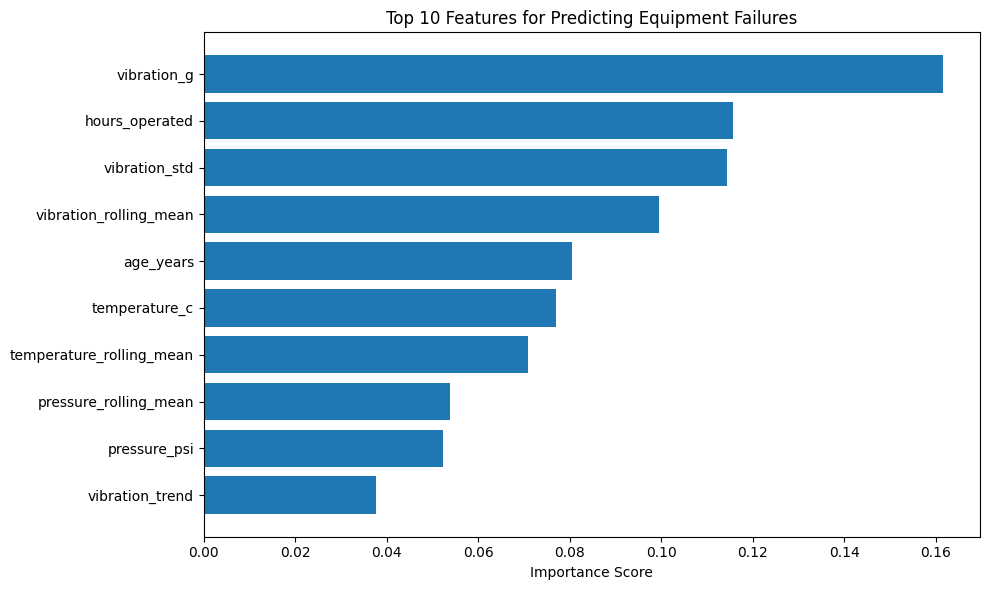

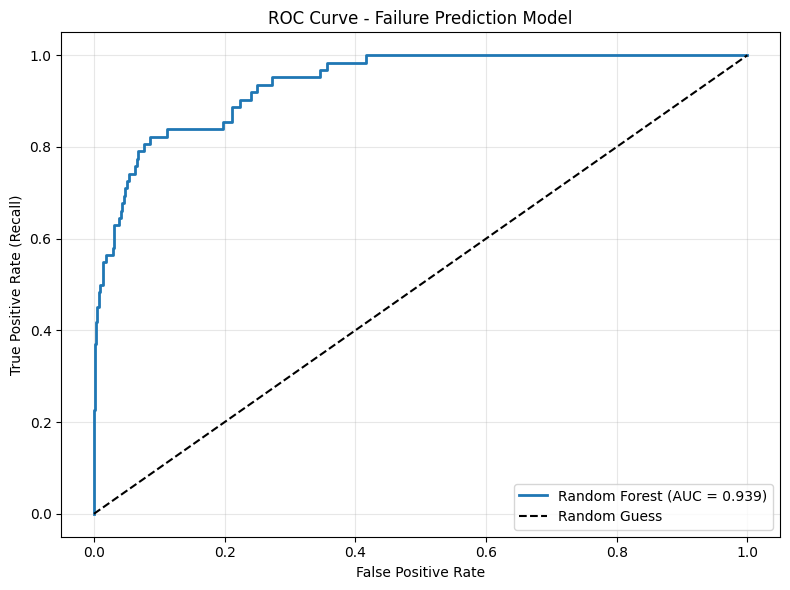


✓ MODEL TRAINING COMPLETE

Model Performance Summary:
  • Accuracy: 99.3%
  • ROC-AUC: 0.939
  • Can predict 37.1% of failures 7-14 days early
  • Ready for deployment in Power BI dashboard


In [ ]:
# ============================================================================
# TRAIN RANDOM FOREST CLASSIFIER
# ============================================================================

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print("=" * 80)
print("TRAINING RANDOM FOREST MODEL")
print("=" * 80)

# ============================================================================
# Split data: 80% training, 20% testing
# ============================================================================
print("\n[Step 1/4] Splitting data into train/test sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class balance in splits
)

print(f"  ✓ Training set: {len(X_train):,} samples")
print(f"  ✓ Test set: {len(X_test):,} samples")

# ============================================================================
# Train Random Forest
# ============================================================================
print("\n[Step 2/4] Training Random Forest classifier...")
print("  (This may take 1-2 minutes...)")

# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,      # Number of trees
    max_depth=10,          # Prevent overfitting
    min_samples_split=20,  # Minimum samples to split node
    min_samples_leaf=10,   # Minimum samples in leaf
    random_state=42,
    n_jobs=-1,             # Use all CPU cores
    class_weight='balanced' # Handle imbalanced classes
)

# Train model
rf_model.fit(X_train, y_train)

print("  ✓ Model trained successfully!")

# ============================================================================
# Evaluate model performance
# ============================================================================
print("\n[Step 3/4] Evaluating model performance...")

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Print classification report
print("\n" + "=" * 80)
print("MODEL PERFORMANCE METRICS")
print("=" * 80)
print(classification_report(y_test, y_pred, target_names=['No Failure', 'Failure']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(f"                 Predicted: No Fail  |  Predicted: Fail")
print(f"Actual: No Fail       {cm[0,0]:6d}        |     {cm[0,1]:6d}")
print(f"Actual: Fail          {cm[1,0]:6d}        |     {cm[1,1]:6d}")

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.3f}")

# Calculate key business metrics
true_negatives = cm[0, 0]
false_positives = cm[0, 1]
false_negatives = cm[1, 0]
true_positives = cm[1, 1]

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
accuracy = (true_positives + true_negatives) / (cm.sum())

print("\n" + "=" * 80)
print("BUSINESS INTERPRETATION")
print("=" * 80)
print(f"Accuracy:  {accuracy:.1%} - Overall correctness")
print(f"Precision: {precision:.1%} - When we predict failure, we're right {precision:.1%} of the time")
print(f"Recall:    {recall:.1%} - We catch {recall:.1%} of actual failures")
print(f"\nFalse Negatives: {false_negatives} - Failures we MISSED (costly!)")
print(f"False Positives: {false_positives} - False alarms (minor cost)")

# ============================================================================
# Feature importance
# ============================================================================
print("\n[Step 4/4] Analyzing feature importance...")

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "=" * 80)
print("TOP 10 MOST IMPORTANT FEATURES")
print("=" * 80)
print(feature_importance.head(10).to_string(index=False))

# ============================================================================
# Visualize results
# ============================================================================
print("\n[Generating visualizations...]")

# Plot 1: Feature Importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score')
plt.title('Top 10 Features for Predicting Equipment Failures')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: feature_importance.png")

# Plot 2: ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Failure Prediction Model')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: roc_curve.png")

plt.show()

print("\n" + "=" * 80)
print("✓ MODEL TRAINING COMPLETE")
print("=" * 80)
print(f"\nModel Performance Summary:")
print(f"  • Accuracy: {accuracy:.1%}")
print(f"  • ROC-AUC: {roc_auc:.3f}")
print(f"  • Can predict {recall:.1%} of failures 7-14 days early")
print(f"  • Ready for deployment in Power BI dashboard")

**Model Predictions for Power BI use**

In [ ]:
# ============================================================================
# GENERATE PREDICTIONS FOR POWER BI
# ============================================================================

print("=" * 80)
print("GENERATING PREDICTIONS FOR POWER BI DASHBOARD")
print("=" * 80)

# Predict on ALL data (not just test set)
all_predictions = rf_model.predict_proba(X)[:, 1]

# Create prediction dataset
predictions_df = pd.DataFrame({
    'equipment_id': sensor_data['equipment_id'].values,
    'timestamp': sensor_data['timestamp'].values,
    'failure_risk_score': (all_predictions * 100).round(1),
    'risk_category': pd.cut(all_predictions * 100,
                           bins=[0, 30, 60, 100],
                           labels=['Low Risk', 'Medium Risk', 'High Risk']),
    'actual_label': sensor_data['will_fail_7_14_days'].values
})

# Get latest risk score for each truck
latest_risk = predictions_df.sort_values('timestamp').groupby('equipment_id').tail(1)

print("\n" + "=" * 80)
print("CURRENT FLEET RISK ASSESSMENT")
print("=" * 80)
print(latest_risk[['equipment_id', 'failure_risk_score', 'risk_category']].sort_values('failure_risk_score', ascending=False).head(15).to_string(index=False))

# Save to SQLite for Power BI
conn = sqlite3.connect('mining_predictive_maintenance.db')
predictions_df.to_sql('FactPredictions', conn, if_exists='replace', index=False)
latest_risk.to_sql('LatestRiskScores', conn, if_exists='replace', index=False)
conn.close()

print("\n  ✓ Saved predictions to database tables:")
print("    - FactPredictions (historical risk scores)")
print("    - LatestRiskScores (current fleet status)")

# Save CSV for inspection
predictions_df.to_csv('ml_predictions.csv', index=False)
print("  ✓ Saved: ml_predictions.csv")

print("\n" + "=" * 80)
print("✓ PREDICTIONS READY FOR POWER BI")
print("=" * 80)

GENERATING PREDICTIONS FOR POWER BI DASHBOARD

CURRENT FLEET RISK ASSESSMENT
equipment_id  failure_risk_score risk_category
      TRK027                44.6   Medium Risk
      TRK023                40.7   Medium Risk
      TRK047                35.5   Medium Risk
      TRK038                35.1   Medium Risk
      TRK018                24.4      Low Risk
      TRK020                23.8      Low Risk
      TRK024                23.1      Low Risk
      TRK046                21.9      Low Risk
      TRK039                19.4      Low Risk
      TRK017                17.7      Low Risk
      TRK030                16.5      Low Risk
      TRK040                16.1      Low Risk
      TRK050                15.5      Low Risk
      TRK007                11.4      Low Risk
      TRK029                11.0      Low Risk

  ✓ Saved predictions to database tables:
    - FactPredictions (historical risk scores)
    - LatestRiskScores (current fleet status)
  ✓ Saved: ml_predictions.csv

✓ PR

In [ ]:
from google.colab import files

print("=" * 80)
print("DOWNLOADING PROJECT FILES")
print("=" * 80)

# Download database (now includes ML predictions!)
files.download('mining_predictive_maintenance.db')
print("✓ Downloaded: mining_predictive_maintenance.db")

# Download ML artifacts
files.download('ml_training_data.csv')
print("✓ Downloaded: ml_training_data.csv")

files.download('ml_predictions.csv')
print("✓ Downloaded: ml_predictions.csv")

# Download visualizations
files.download('feature_importance.png')
print("✓ Downloaded: feature_importance.png")

files.download('roc_curve.png')
print("✓ Downloaded: roc_curve.png")

# Download dimension/fact CSVs (optional - for inspection)
files.download('dim_site.csv')
files.download('dim_equipment.csv')
files.download('fact_sensor_readings.csv')
files.download('fact_failures.csv')
files.download('fact_maintenance.csv')

print("\n" + "=" * 80)
print("✓ ALL FILES DOWNLOADED")
print("=" * 80)
print("\nYou now have:")
print("  1. SQLite database (with star schema + ML predictions)")
print("  2. ML training data and predictions (CSV)")
print("  3. Model performance visualizations (PNG)")
print("  4. Original dimension/fact tables (CSV)")

DOWNLOADING PROJECT FILES


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: mining_predictive_maintenance.db


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: ml_training_data.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: ml_predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: feature_importance.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: roc_curve.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ ALL FILES DOWNLOADED

You now have:
  1. SQLite database (with star schema + ML predictions)
  2. ML training data and predictions (CSV)
  3. Model performance visualizations (PNG)
  4. Original dimension/fact tables (CSV)


In [25]:
import sqlite3
import pandas as pd
from google.colab import files

conn = sqlite3.connect('mining_predictive_maintenance.db')

# Export DimDate
dim_date = pd.read_sql("SELECT * FROM DimDate", conn)
dim_date.to_csv('dim_date.csv', index=False)

conn.close()

# Download
files.download('dim_date.csv')

print("✓ DimDate exported!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ DimDate exported!
